# Introduction

- April Competition 설명
    - 타이타닉 대회 데이터 기반
    - 추가로 GAN을 이용하여 데이터를 추가 생성 (원본 데이터 만으로 높은 점수를 받을 수 없게 했음)

# General

In [4]:
import os
import joblib
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## 데이터 로드

In [5]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

## Numbers of rows and columns

In [6]:
print('Rows and Columns in train dataset:', train_df.shape)
print('Rows and Columns in test dataset:', test_df.shape)

Rows and Columns in train dataset: (100000, 12)
Rows and Columns in test dataset: (100000, 11)


- train, test 데이터 모두 10만 행 존재
- test 데이터는 target 데이터인 Survived가 빠져 11개의 열로 이루어짐

## Numbers of missing values

In [7]:
print('Missing values in train dataset:', sum(train_df.isnull().sum()))
print('Missing values in test dataset:', sum(test_df.isnull().sum()))

Missing values in train dataset: 76165
Missing values in test dataset: 79909


- train 데이터에는 결측치 76165개
- test 데이터는 79909개

In [8]:
# train 데이터 결측치
print('Missing values per columns in train dataset')
for col in train_df.columns:
    temp_col = train_df[col].isnull().sum()
    print(f'{col}: {temp_col}')

Missing values per columns in train dataset
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 3292
SibSp: 0
Parch: 0
Ticket: 4623
Fare: 134
Cabin: 67866
Embarked: 250


In [9]:
# test 데이터 결측치
print('Missing values per columns in test dataset')
for col in test_df.columns:
    temp_col = test_df[col].isnull().sum()
    print(f'{col}: {temp_col}')

Missing values per columns in test dataset
PassengerId: 0
Pclass: 0
Name: 0
Sex: 0
Age: 3487
SibSp: 0
Parch: 0
Ticket: 5181
Fare: 133
Cabin: 70831
Embarked: 277


- 결측값이 있는 피쳐는 연령(age), 승차권(Ticket), 요금(Fare), 객실(Cabin) 및 탑승 항구(Embarked)

- 결측값의 대부분은 객실(약 90%)

## First 5 rows

In [10]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [11]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


# Features

## Features descriptions

데이터에는 다음 정보가 포함

- Pclass - 사회-경제적 지위를 나타내는 지표, 여기서 1: 상위 계층, 2: 중위 계층, 3: 하위 계층 (비행기 퍼스트, 비지니스, 이코노미 생각하면 됨)
- Sex - 남성과 여성.
- Age - 나이
- SibSp - 배에 탑승한 형제자매/배우자의 수. 형제자매는 형제, 자매, 의붓자매이며 배우자는 남편과 아내
- Parch - 배에 탑승한 부모/자녀의 수, 부모는 어머니와 아버지, 아이는 딸, 아들, 의붓딸, 의붓아들. 아이가 유모와 함께 탑승한 경우에 Parch 0
- Fare - 승객 요금.
- Cabin - 객실 번호
- Emarked - 승객이 탑승한 항구 이름의 이니셜. C는 셰르부르, Q는 퀸스타운, S는 사우샘프턴
- Ticket - 티켓 번호.
- Name - 승객 이름.
- Survived - 0은 사망, 1은 생존

## Features comparison

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


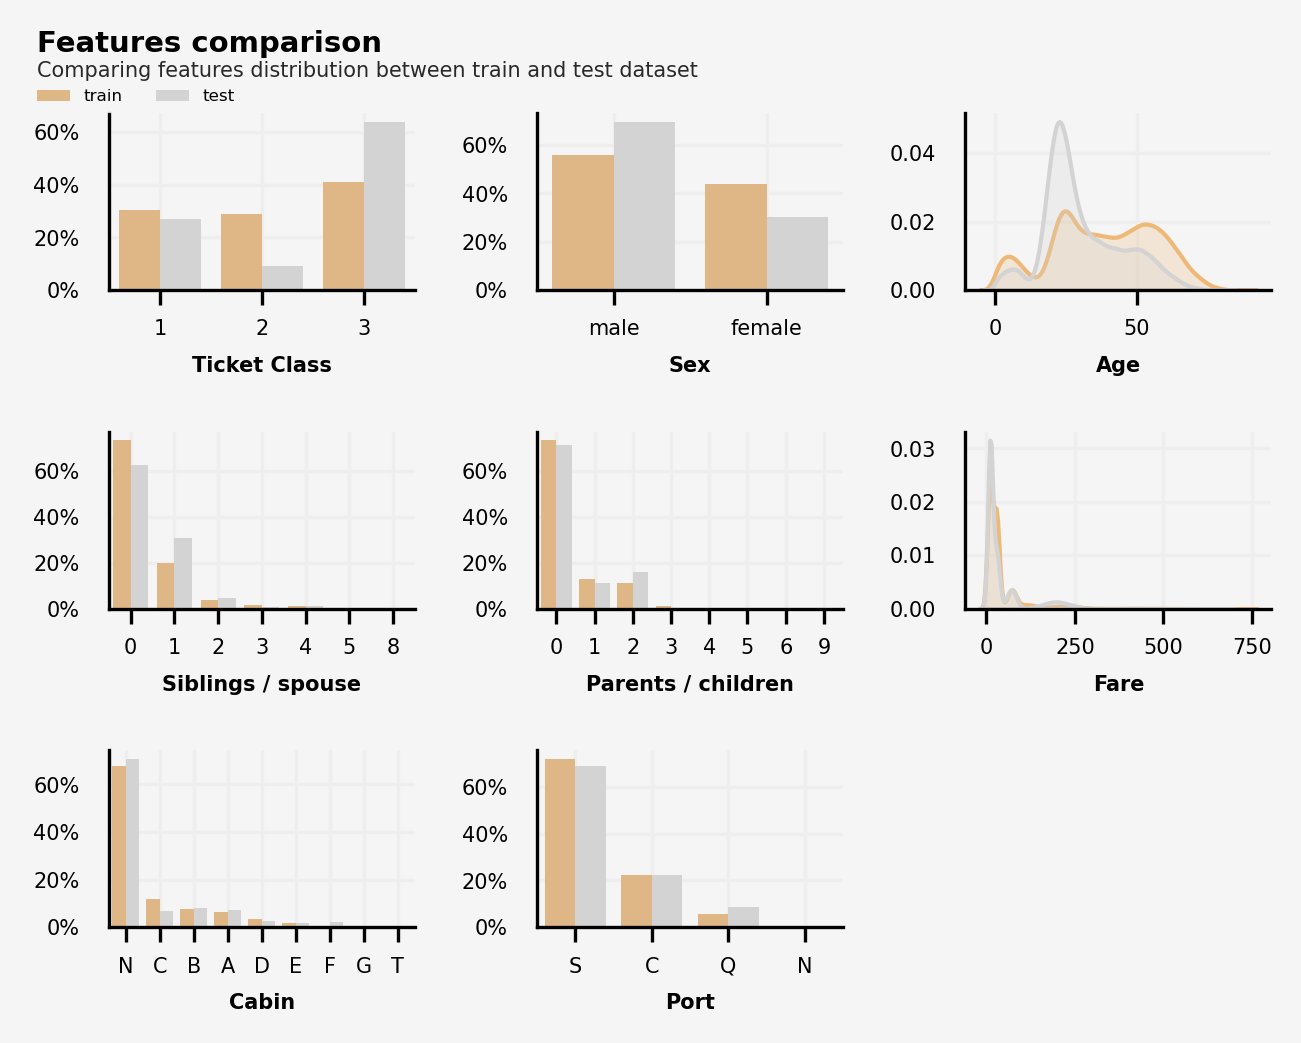

In [12]:
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(5, 5), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.4, hspace=0.8)

background_color = "#f6f5f5"
color_map = ['#eeb977', 'lightgray']
sns.set_palette(sns.color_palette(color_map))

column = 'Pclass'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0.tick_params(axis = "y", which = "both", left = False)
ax0.text(-1.2, 88, 'Features comparison', color='black', fontsize=7, ha='left', va='bottom', weight='bold')
ax0.text(-1.2, 87, 'Comparing features distribution between train and test dataset', color='#292929', fontsize=5, ha='left', va='top')
ax0_sns = sns.barplot(ax=ax0, x=temp_combine['index'], y=temp_combine[column]/1000, zorder=2, hue=temp_combine['source'])
ax0_sns.set_xlabel("Ticket Class",fontsize=5, weight='bold')
ax0_sns.set_ylabel('')
ax0.yaxis.set_major_formatter(ticker.PercentFormatter())
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)
ax0_sns.legend(ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=4, bbox_to_anchor=(0.46, 1.22))

column = 'Sex'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax1 = fig.add_subplot(gs[0, 1])
for s in ["right", "top"]:
    ax1.spines[s].set_visible(False)
ax1.set_facecolor(background_color)
ax1.legend(prop={'size': 3})
ax1.tick_params(axis = "y", which = "both", left = False)
ax1_sns = sns.barplot(ax=ax1, x=temp_combine['index'], y=temp_combine[column]/1000, zorder=2, hue=temp_combine['source'])
ax1_sns.set_xlabel('Sex', fontsize=5, weight='bold')
ax1_sns.set_ylabel('')
ax1.yaxis.set_major_formatter(ticker.PercentFormatter())
ax1_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax1_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax1_sns.tick_params(labelsize=5)
ax1_sns.get_legend().remove()

column = 'Age'
ax3 = fig.add_subplot(gs[0, 2])
for s in ["right", "top"]:
    ax3.spines[s].set_visible(False)
ax3.set_facecolor(background_color)
ax3.legend(prop={'size': 3})
ax3.tick_params(axis = "y", which = "both", left = False)
ax3_sns = sns.kdeplot(ax=ax3, x=train_df['Age'], zorder=2, shade=True)
ax3_sns = sns.kdeplot(ax=ax3, x=test_df['Age'], zorder=2, shade=True)
ax3_sns.set_xlabel('Age', fontsize=5, weight='bold')
ax3_sns.set_ylabel('')
ax3_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax3_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax3_sns.tick_params(labelsize=5)
ax3_sns.get_legend().remove()

column = 'SibSp'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax4 = fig.add_subplot(gs[1, 0])
for s in ["right", "top"]:
    ax4.spines[s].set_visible(False)
ax4.set_facecolor(background_color)
ax4.legend(prop={'size': 3})
ax4.tick_params(axis = "y", which = "both", left = False)
ax4_sns = sns.barplot(ax=ax4, x=temp_combine['index'], y=temp_combine[column]/1000, zorder=2, hue=temp_combine['source'])
ax4_sns.set_xlabel('Siblings / spouse', fontsize=5, weight='bold')
ax4_sns.set_ylabel('')
ax4.yaxis.set_major_formatter(ticker.PercentFormatter())
ax4_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax4_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax4_sns.tick_params(labelsize=5)
ax4_sns.get_legend().remove()

column = 'Parch'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax5 = fig.add_subplot(gs[1, 1])
for s in ["right", "top"]:
    ax5.spines[s].set_visible(False)
ax5.set_facecolor(background_color)
ax5.legend(prop={'size': 3})
ax5.tick_params(axis = "y", which = "both", left = False)
ax5_sns = sns.barplot(ax=ax5, x=temp_combine['index'], y=temp_combine[column]/1000, zorder=2, hue=temp_combine['source'])
ax5_sns.set_xlabel('Parents / children', fontsize=5, weight='bold')
ax5_sns.set_ylabel('')
ax5.yaxis.set_major_formatter(ticker.PercentFormatter())
ax5_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax5_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax5_sns.tick_params(labelsize=5)
ax5_sns.get_legend().remove()

column = 'Fare'
ax6 = fig.add_subplot(gs[1, 2])
for s in ["right", "top"]:
    ax6.spines[s].set_visible(False)
ax6.set_facecolor(background_color)
ax6.legend(prop={'size': 3})
ax6.tick_params(axis = "y", which = "both", left = False)
ax6_sns = sns.kdeplot(ax=ax6, x=train_df['Fare'], zorder=2, shade=True)
ax6_sns = sns.kdeplot(ax=ax6, x=test_df['Fare'], zorder=2, shade=True)
ax6_sns.set_xlabel('Fare', fontsize=5, weight='bold')
ax6_sns.set_ylabel('')
ax6_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax6_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax6_sns.tick_params(labelsize=5)
ax6_sns.get_legend().remove()

train_df["Cabin"] = train_df["Cabin"].fillna("No")
train_df["Cabin_code"] = train_df["Cabin"].str[0]
test_df["Cabin"] = test_df["Cabin"].fillna("No")
test_df["Cabin_code"] = test_df["Cabin"].str[0]

column = 'Cabin_code'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax7 = fig.add_subplot(gs[2, 0])
for s in ["right", "top"]:
    ax7.spines[s].set_visible(False)
ax7.set_facecolor(background_color)
ax7.legend(prop={'size': 3})
ax7.tick_params(axis = "y", which = "both", left = False)
ax7_sns = sns.barplot(ax=ax7, x=temp_combine['index'], y=temp_combine[column]/1000, zorder=2, hue=temp_combine['source'])
ax7_sns.set_xlabel('Cabin', fontsize=5, weight='bold')
ax7_sns.set_ylabel('')
ax7.yaxis.set_major_formatter(ticker.PercentFormatter())
ax7_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax7_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax7_sns.tick_params(labelsize=5)
ax7_sns.get_legend().remove()

train_df["Embarked"] = train_df["Embarked"].fillna("N")
test_df["Embarked"] = test_df["Embarked"].fillna("N")

column = 'Embarked'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax8 = fig.add_subplot(gs[2, 1])
for s in ["right", "top"]:
    ax8.spines[s].set_visible(False)
ax8.set_facecolor(background_color)
ax8.legend(prop={'size': 3})
ax8.tick_params(axis = "y", which = "both", left = False)
ax8_sns = sns.barplot(ax=ax8, x=temp_combine['index'], y=temp_combine[column]/1000, zorder=2, hue=temp_combine['source'])
ax8_sns.set_xlabel('Port', fontsize=5, weight='bold')
ax8_sns.set_ylabel('')
ax8.yaxis.set_major_formatter(ticker.PercentFormatter())
ax8_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax8_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax8_sns.tick_params(labelsize=5)
ax8_sns.get_legend().remove()

plt.show()

Pclass(Ticket Class)

- 각 클래스 간의 비율은 train와 test에서 서로 다름
- train 데이터 집합의 class 3은 40% 차지, test 데이터 세트에서는 60% 이상 차지.
- class 2는 test 데이터 세트에서 10%로 매우 낮은 반면 train 데이터 세트에서는 약 30%
- train 및 test 데이터 세트의 class 1은 거의 동일하지만 train 데이터 세트가 살짝 더 많음

Sex

- 남녀 비율이 train와 test에서 서로 다름
- 남성들은 train와 test에서 데이터 세트에 50% 이상의 비율 차지
- 여성의 경우 train에서 약 30%, test에서 약 60%

Age

- 약 15세에서 40세 사이에서 서로 다른 분포를 가짐
- train 및 test 데이터 세트에 결측값이 있으며 각각 3,292와 3,487이다. (위에서 확인한 사항)

Sibsp

- 형제자매/배우자 수는 7가지 범주로 분류할 수 있음
- train와 test 데이터 세트 간에 1명의 형제자매/배우자와 함께 여행하는 승객에 대해 10%의 차이가 존재
- 승객과 함께 탑승하는 형제자매/배우자 중 가장 많은 수가 8명, 가장 낮은 숫자는 형제/배우자 없이 여행하는 것
- 대부분의 승객들은 혼자 탑승

Parch

- 부모/자녀 수를 8개 범주로 분류할 수 있음
- 부모/자녀 수가 가장 많은 8명이고 가장 낮은 0명은 승객들이 부모/자녀 없이 여행 중이라는 뜻
- 마찬가지로 승객들이 혼자 여행하고 있음을 알 수 있음

Fare

- train와 test 데이터 세트 간의 요금 분포는 매우 유사하나, 낮은 요금에서는 약간의 차이 존재
- train 데이터 세트에서 가장 높은 요금은 744.66, test 데이터 세트에서는 680.7
- train과 test 데이터 세트에서 가장 낮은 요금은 각각 0.05와 0.68
- 평균 요금은 train 데이터 세트 43.9와 test 데이터 세트 45.4로, 두 데이터 세트 간의 차이가 크지 않음
- 결측치는 train 데이터 세트에서 134이고 test 데이터 세트에서 133(위에서 확인한 사항)

Cabin

- 객실 번호는 피쳐의 첫 번째 알파벳를 추출해서 나타냄
- train 데이터 세트에서 67,866개의 결측값과 test 데이터 세트에서 70,831개의 가장 많은 결측값을 가지고 있음
- 전체 데이터가 10만개이므로 정보의 거의 70%가 누락되었음을 의미
- 객실 번호가 없는 승객(결측치)을 대상은 N으로 나타냄
- 객실은 9가지 범주로 분류할 수 있음
- 객실 C의 train와 test 데이터 세트는 어느정도 차이 존재

Embarked

- 마찬가지로 항구 정보가 없는 승객(결측치)를 N으로 처리
- 대부분의 승객(약 70%)은 사우샘프턴에서 출발
- train 데이터 세트에는 205개의 결측값이 있고 test 데이터 세트에는 277개의 결측값 존재

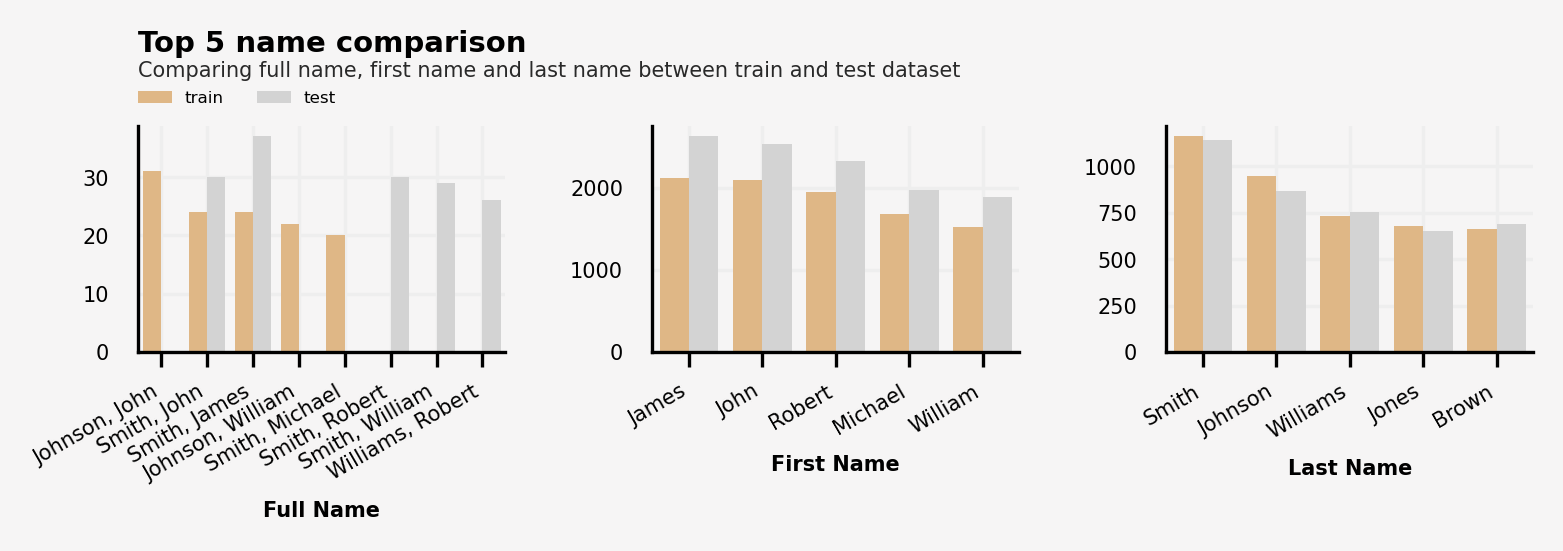

In [13]:
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(6, 1), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 3)
gs.update(wspace=0.4, hspace=0.8)

background_color = "#f6f5f5"
color_map = ['#eeb977', 'lightgray']
sns.set_palette(sns.color_palette(color_map))

column = 'Name'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train = temp_train.iloc[:5, :]
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test = temp_test.iloc[:5, :]
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0.tick_params(axis = "y", which = "both", left = False)
ax0.text(-0.5, 50.5, 'Top 5 name comparison', color='black', fontsize=7, ha='left', va='bottom', weight='bold')
ax0.text(-0.5, 50, 'Comparing full name, first name and last name between train and test dataset', color='#292929', fontsize=5, ha='left', va='top')
ax0_sns = sns.barplot(ax=ax0, x=temp_combine['index'], y=temp_combine[column], zorder=2, hue=temp_combine['source'])
ax0_sns.set_xlabel("Full Name",fontsize=5, weight='bold')
ax0_sns.set_xticklabels(ax0_sns.get_xticklabels(), rotation = 30, ha="right")
ax0_sns.set_ylabel('')
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)
ax0_sns.legend(ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=4, bbox_to_anchor=(0.58, 1.22))

column = 'FirstName'
train_df = pd.concat([train_df, train_df['Name'].str.split(',', expand=True)], axis=1)
train_df = train_df.rename(columns={0:'LastName', 1: 'FirstName'})
train_df['FirstName'] = train_df["FirstName"].str[1:]
train_df['LastName'] = train_df["LastName"].str[0:]
test_df = pd.concat([test_df, test_df['Name'].str.split(',', expand=True)], axis=1)
test_df = test_df.rename(columns={0:'LastName', 1: 'FirstName'})
test_df['FirstName'] = test_df["FirstName"].str[1:]
test_df['LastName'] = test_df["LastName"].str[0:]
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train = temp_train.iloc[:5, :]
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test = temp_test.iloc[:5, :]
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax1 = fig.add_subplot(gs[0, 1])
for s in ["right", "top"]:
    ax1.spines[s].set_visible(False)
ax1.set_facecolor(background_color)
ax1.tick_params(axis = "y", which = "both", left = False)
ax1_sns = sns.barplot(ax=ax1, x=temp_combine['index'], y=temp_combine[column], zorder=2, hue=temp_combine['source'])
ax1_sns.set_xlabel("First Name",fontsize=5, weight='bold')
ax1_sns.set_xticklabels(ax1_sns.get_xticklabels(), rotation = 30, ha="right")
ax1_sns.set_ylabel('')
ax1_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax1_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax1_sns.tick_params(labelsize=5)
ax1_sns.get_legend().remove()

column = 'LastName'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train = temp_train.iloc[:5, :]
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test = temp_test.iloc[:5, :]
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)

ax2 = fig.add_subplot(gs[0, 2])
for s in ["right", "top"]:
    ax2.spines[s].set_visible(False)
ax2.set_facecolor(background_color)
ax2.tick_params(axis = "y", which = "both", left = False)
ax2_sns = sns.barplot(ax=ax2, x=temp_combine['index'], y=temp_combine[column], zorder=2, hue=temp_combine['source'])
ax2_sns.set_xlabel("Last Name",fontsize=5, weight='bold')
ax2_sns.set_xticklabels(ax2_sns.get_xticklabels(), rotation = 30, ha="right")
ax2_sns.set_ylabel('')
ax2_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax2_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax2_sns.tick_params(labelsize=5)
ax2_sns.get_legend().remove()

Full name

- train와 test 사이의 상위 5개의 풀네임은 다르고, 가장 많이 나오는 train의 풀네임은 Johnson, John, 가장 많이 나오는 test의 이름은 Smith, James
- Johnson, William 및 Smith, Michael은 test 데이터 세트의 상위 5개 풀네임에 속하지 않지만 개별 이름은 존재
- 반대로 train 데이터 세트에서는 Smith, Robert 와 Smith, William가 위 케이스에 해당
- 같은 풀네임을 가진 승객들은 매우 작다고 볼 수 있음 (많아봤자 30여명)

First name

- 상위 5명의 이름은 train와 test 데이터 세트 사이에서 James, John, Robert, Michael, William 순으로 동일
- test 데이터 세트에서 상위 5명의 승객 이름이 train 데이터 세트에 비해 더 많음
- 이름이 같은 승객은 1,000명에서 2,500명 사이

Last name

- 상위 5명의 성은 train와 test 데이터 세트 간에 Smith, Johnson, Williams, Jones, Brown 으로 동일
- train과 test 데이터 세트의 크기가 거의 비슷함
- 성이 같은 승객은 500명에서 1,500명 사이

No handles with labels found to put in legend.


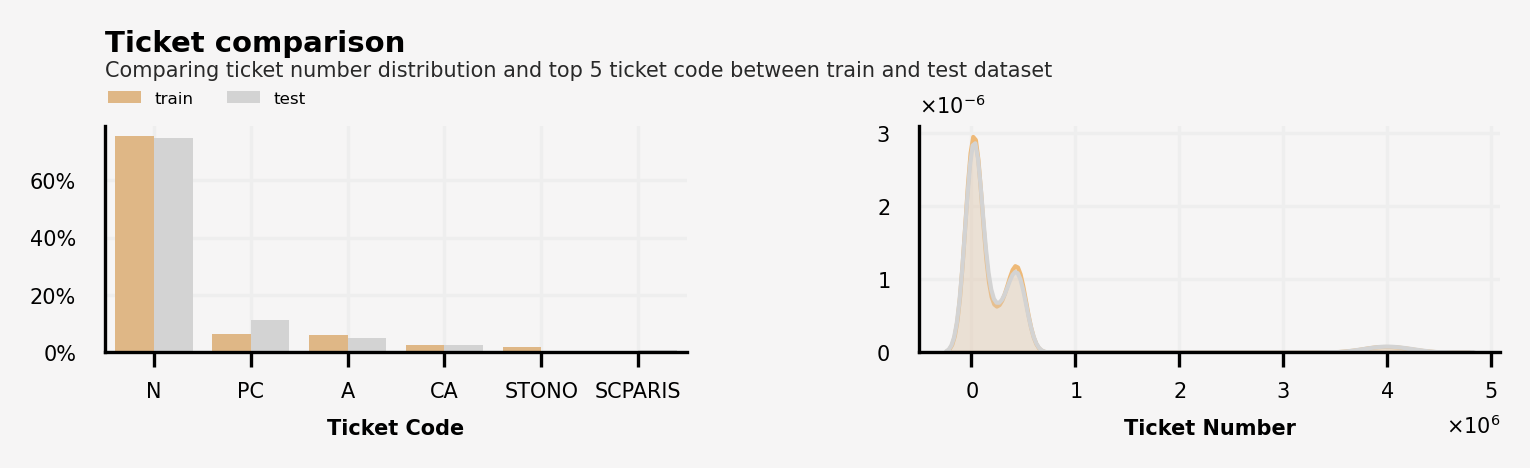

In [14]:
train_df['TicketCode'] = train_df['Ticket'].str.extract('(\D+)')
train_df['TicketCode'] = train_df['TicketCode'].str.replace('[^\w\s]','')
train_df['TicketCode'] = train_df['TicketCode'].str.replace(' ','')
train_df['TicketNumber'] = train_df['Ticket'].str.extract('(\d+)')
train_df['TicketNumber'] = train_df['TicketNumber'].astype(float)
train_df['TicketCode'] = train_df['TicketCode'].fillna('N')
train_df['TicketNumber'] = train_df['TicketNumber'].fillna(0)
test_df['TicketCode'] = test_df['Ticket'].str.extract('(\D+)')
test_df['TicketCode'] = test_df['TicketCode'].str.replace('[^\w\s]','')
test_df['TicketCode'] = test_df['TicketCode'].str.replace(' ','')
test_df['TicketNumber'] = test_df['Ticket'].str.extract('(\d+)')
test_df['TicketNumber'] = test_df['TicketNumber'].astype(float)
test_df['TicketCode'] = test_df['TicketCode'].fillna('N')
test_df['TicketNumber'] = test_df['TicketNumber'].fillna(0)

plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(6, 1), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.4, hspace=0.8)

background_color = "#f6f5f5"
color_map = ['#eeb977', 'lightgray']
sns.set_palette(sns.color_palette(color_map))

column = 'TicketCode'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train = temp_train.iloc[:5, :]
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test = temp_test.iloc[:5, :]
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0.tick_params(axis = "y", which = "both", left = False)
ax0.text(-0.5, 103, 'Ticket comparison', color='black', fontsize=7, ha='left', va='bottom', weight='bold')
ax0.text(-0.5, 102, 'Comparing ticket number distribution and top 5 ticket code between train and test dataset', color='#292929', fontsize=5, ha='left', va='top')
ax0_sns = sns.barplot(ax=ax0, x=temp_combine['index'], y=temp_combine[column]/1000, zorder=2, hue=temp_combine['source'])
ax0_sns.set_xlabel("Ticket Code",fontsize=5, weight='bold')
ax0_sns.set_ylabel('')
ax0.yaxis.set_major_formatter(ticker.PercentFormatter())
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)
ax0_sns.legend(ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=4, bbox_to_anchor=(0.37, 1.22))

column = 'TicketNumber'
ax1 = fig.add_subplot(gs[0, 1])
for s in ["right", "top"]:
    ax1.spines[s].set_visible(False)
ax1.set_facecolor(background_color)
ax1.legend(prop={'size': 3})
ax1.tick_params(axis = "y", which = "both", left = False)
ax1_sns = sns.kdeplot(ax=ax1, x=train_df[column], zorder=2, shade=True)
ax1_sns = sns.kdeplot(ax=ax1, x=test_df[column], zorder=2, shade=True)
ax1_sns.set_xlabel('Ticket Number', fontsize=5, weight='bold')
ax1_sns.set_ylabel('')
ax1_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax1_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax1_sns.tick_params(labelsize=5)
ax1_sns.get_legend().remove()
ax1_sns.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
ax1_sns.yaxis.get_offset_text().set_fontsize(5)
ax1_sns.xaxis.get_offset_text().set_fontsize(5)

plt.show()

Ticket

- 티켓은 티켓 코드와 티켓 번호 두 가지로 구분할 수 있음
- 티켓 코드는 숫자가 아닌 형태로 범주화, 티켓 번호는 숫자 형태로 범주화
- 일부 티켓은 결측치임. 이를 티켓 코드의 결측치는 N, 티켓 번호의 결측치는 0으로 바꿈
- 마침표 정보를 전부 삭제

Ticket code

- 약 60%가 N임 = 약 60%가 결측치임
- 나머지 범주를 다 합쳐도 20%가 되지 않음


Ticket number

- train 데이터에 5,296개, test 데이터에 5,817개의 티켓 번호 결측치가 존재(0으로 분류된 값)
- train, test 데이터 사이에 티켓 번호 분포가 유사

# Survival Rate

## Calculation method
생존율을 계산하는 두 가지 방법:

- a. 총 관측치 10만 명을 각 카테고리에서 생존한 승객으로나눔
- b. 해당 카테고리의 승객으로 특정 카테고리 내의 생존한 승객으로 나눔

__예시__:

티켓 클래스는 3개 클래스(1,2,3)가 있으며, 1클래스 승객은 30,315명이고 이 중 생존 승객은 17,576명. 위의 참고 사항에 따라 생존율은 다음과 같음

- a의 생존율은 17,576 / 100,000 = 17.6%.
- b의 생존율은 17,576 / 30,315 = 58%

여기서는 a의 방식으로 생존율을 계산

## Feature survival rate

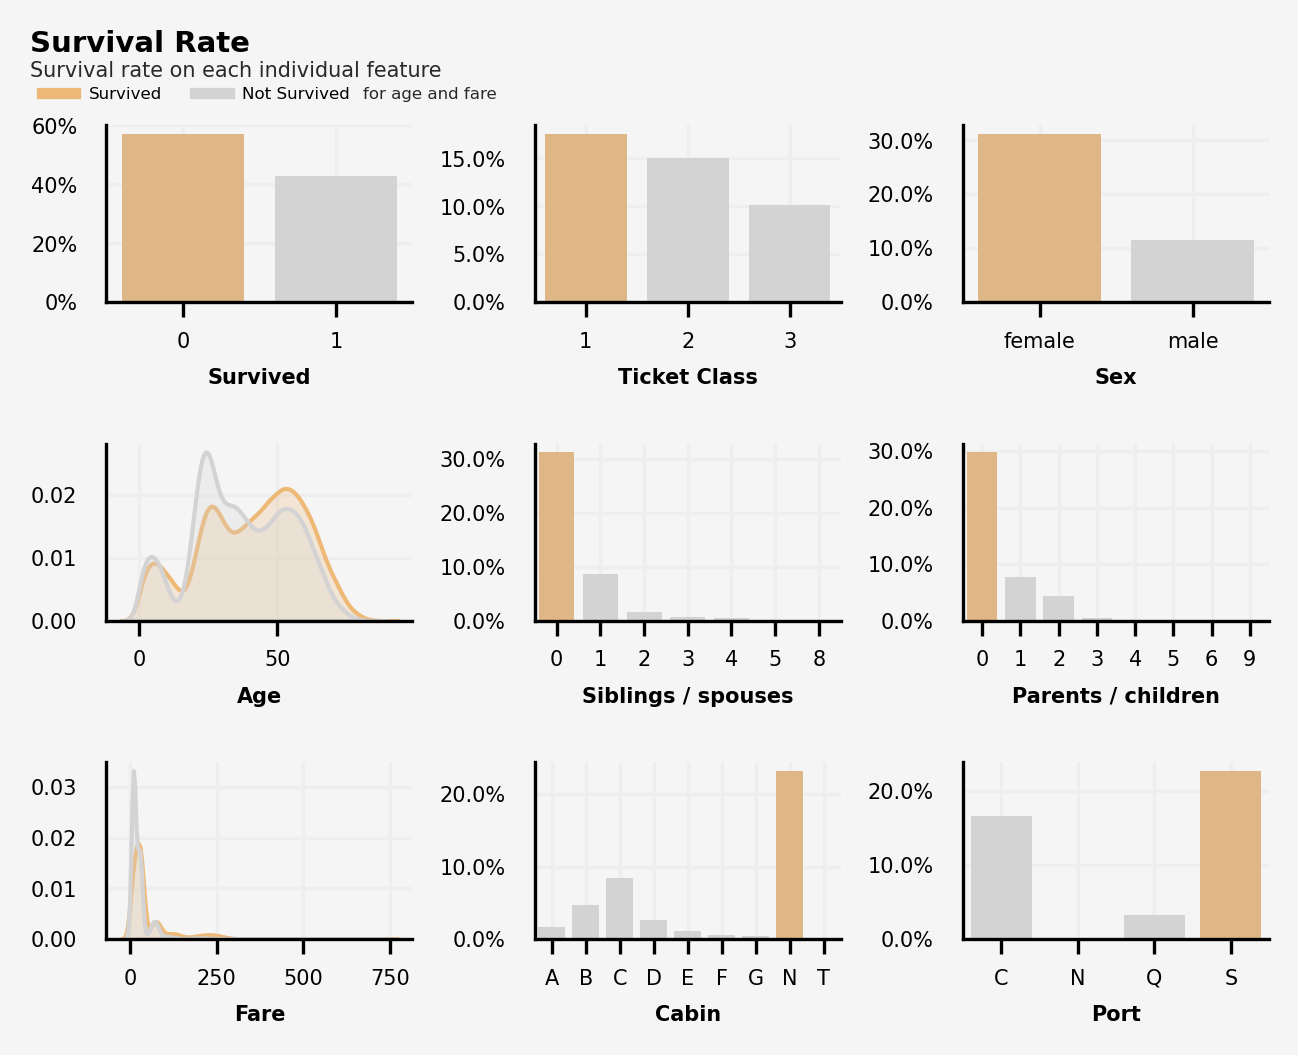

In [15]:
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(5, 5), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.4, hspace=0.8)

background_color = "#f6f5f5"

column = 'Survived'
color_map = ['#eeb977', 'lightgray']
sns.set_palette(sns.color_palette(color_map))
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0.tick_params(axis = "y", which = "both", left = False)
ax0.text(-1, 83, 'Survival Rate', color='black', fontsize=7, ha='left', va='bottom', weight='bold')
ax0.text(-1, 82, 'Survival rate on each individual feature', color='#292929', fontsize=5, ha='left', va='top')
ax0.text(1.18, 73.3, 'for age and fare', color='#292929', fontsize=4, ha='left', va='top')
ax0_sns = sns.barplot(ax=ax0, x=temp_train['index'], y=temp_train[column]/1000, zorder=2)
ax0_sns.set_xlabel("Survived",fontsize=5, weight='bold')
ax0_sns.set_ylabel('')
ax0.yaxis.set_major_formatter(ticker.PercentFormatter())
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)
ax0_sns.legend(['Survived', 'Not Survived'], ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=4, bbox_to_anchor=(-0.26, 1.3), loc='upper left')
leg = ax0_sns.get_legend()
leg.legendHandles[0].set_color('#eeb977')
leg.legendHandles[1].set_color('lightgray')

column = 'Pclass'
color_map = ['#eeb977', 'lightgray', 'lightgray']
sns.set_palette(sns.color_palette(color_map))
temp_train = train_df.groupby(column)['Survived'].sum()
ax1 = fig.add_subplot(gs[0, 1])
for s in ["right", "top"]:
    ax1.spines[s].set_visible(False)
ax1.set_facecolor(background_color)
ax1.tick_params(axis = "y", which = "both", left = False)
ax1_sns = sns.barplot(ax=ax1, x=temp_train.index, y=temp_train/1000, zorder=2)
ax1_sns.set_xlabel("Ticket Class",fontsize=5, weight='bold')
ax1_sns.set_ylabel('')
ax1.yaxis.set_major_formatter(ticker.PercentFormatter())
ax1_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax1_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax1_sns.tick_params(labelsize=5)

column = 'Sex'
color_map = ['#eeb977', 'lightgray']
sns.set_palette(sns.color_palette(color_map))
temp_train = train_df.groupby(column)['Survived'].sum()
ax2 = fig.add_subplot(gs[0, 2])
for s in ["right", "top"]:
    ax2.spines[s].set_visible(False)
ax2.set_facecolor(background_color)
ax2.tick_params(axis = "y", which = "both", left = False)
ax2_sns = sns.barplot(ax=ax2, x=temp_train.index, y=temp_train/1000, zorder=2)
ax2_sns.set_xlabel("Sex",fontsize=5, weight='bold')
ax2_sns.set_ylabel('')
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax2_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax2_sns.tick_params(labelsize=5)

column = 'Age'
color_map = ['#eeb977', 'lightgray']
sns.set_palette(sns.color_palette(color_map))
temp_train = train_df.groupby(column)['Survived'].sum()
ax3 = fig.add_subplot(gs[1, 0])
for s in ["right", "top"]:
    ax3.spines[s].set_visible(False)
ax3.set_facecolor(background_color)
ax3.tick_params(axis = "y", which = "both", left = False)
ax3_sns = sns.kdeplot(ax=ax3, x=train_df[train_df['Survived']==1]['Age'], zorder=2, shade=True)
ax3_sns = sns.kdeplot(ax=ax3, x=train_df[train_df['Survived']==0]['Age'], zorder=2, shade=True)
ax3_sns.set_xlabel("Age",fontsize=5, weight='bold')
ax3_sns.set_ylabel('')
ax3_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax3_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax3_sns.tick_params(labelsize=5)

column = 'SibSp'
color_map = ['lightgray' for _ in range(7)]
color_map[0] = '#eeb977'
sns.set_palette(sns.color_palette(color_map))
temp_train = train_df.groupby(column)['Survived'].sum()
ax4 = fig.add_subplot(gs[1, 1])
for s in ["right", "top"]:
    ax4.spines[s].set_visible(False)
ax4.set_facecolor(background_color)
ax4.tick_params(axis = "y", which = "both", left = False)
ax4_sns = sns.barplot(ax=ax4, x=temp_train.index, y=temp_train/1000, zorder=2)
ax4_sns.set_xlabel("Siblings / spouses",fontsize=5, weight='bold')
ax4_sns.set_ylabel('')
ax4.yaxis.set_major_formatter(ticker.PercentFormatter())
ax4_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax4_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax4_sns.tick_params(labelsize=5)

column = 'Parch'
color_map = ['lightgray' for _ in range(8)]
color_map[0] = '#eeb977'
sns.set_palette(sns.color_palette(color_map))
temp_train = train_df.groupby(column)['Survived'].sum()
ax5 = fig.add_subplot(gs[1, 2])
for s in ["right", "top"]:
    ax5.spines[s].set_visible(False)
ax5.set_facecolor(background_color)
ax5.tick_params(axis = "y", which = "both", left = False)
ax5_sns = sns.barplot(ax=ax5, x=temp_train.index, y=temp_train/1000, zorder=2)
ax5_sns.set_xlabel("Parents / children",fontsize=5, weight='bold')
ax5_sns.set_ylabel('')
ax5.yaxis.set_major_formatter(ticker.PercentFormatter())
ax5_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax5_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax5_sns.tick_params(labelsize=5)

column = 'Fare'
color_map = ['#eeb977', 'lightgray']
sns.set_palette(sns.color_palette(color_map))
temp_train = train_df.groupby(column)['Survived'].sum()
ax6 = fig.add_subplot(gs[2, 0])
for s in ["right", "top"]:
    ax6.spines[s].set_visible(False)
ax6.set_facecolor(background_color)
ax6.tick_params(axis = "y", which = "both", left = False)
ax6_sns = sns.kdeplot(ax=ax6, x=train_df[train_df['Survived']==1]['Fare'], zorder=2, shade=True)
ax6_sns = sns.kdeplot(ax=ax6, x=train_df[train_df['Survived']==0]['Fare'], zorder=2, shade=True)
ax6_sns.set_xlabel("Fare",fontsize=5, weight='bold')
ax6_sns.set_ylabel('')
ax6_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax6_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax6_sns.tick_params(labelsize=5)

column = 'Cabin_code'
color_map = ['lightgray' for _ in range(9)]
color_map[7] = '#eeb977'
sns.set_palette(sns.color_palette(color_map))
temp_train = train_df.groupby(column)['Survived'].sum()
ax7 = fig.add_subplot(gs[2, 1])
for s in ["right", "top"]:
    ax7.spines[s].set_visible(False)
ax7.set_facecolor(background_color)
ax7.tick_params(axis = "y", which = "both", left = False)
ax7_sns = sns.barplot(ax=ax7, x=temp_train.index, y=temp_train/1000, zorder=2)
ax7_sns.set_xlabel("Cabin",fontsize=5, weight='bold')
ax7_sns.set_ylabel('')
ax7.yaxis.set_major_formatter(ticker.PercentFormatter())
ax7_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax7_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax7_sns.tick_params(labelsize=5)

column = 'Embarked'
color_map = ['lightgray' for _ in range(4)]
color_map[3] = '#eeb977'
sns.set_palette(sns.color_palette(color_map))
temp_train = train_df.groupby(column)['Survived'].sum()
ax8 = fig.add_subplot(gs[2, 2])
for s in ["right", "top"]:
    ax8.spines[s].set_visible(False)
ax8.set_facecolor(background_color)
ax8.tick_params(axis = "y", which = "both", left = False)
ax8_sns = sns.barplot(ax=ax8, x=temp_train.index, y=temp_train/1000, zorder=2)
ax8_sns.set_xlabel("Port",fontsize=5, weight='bold')
ax8_sns.set_ylabel('')
ax8.yaxis.set_major_formatter(ticker.PercentFormatter())
ax8_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax8_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax8_sns.tick_params(labelsize=5)

Survived

- 사고 당시 생존하지 못한 승객은 57226명, 생존자는 42774명으로 생존율은 약 42.8%

Pclass

- 클래스 1은 생존율이 17.6%로 가장 높고, 클래스 2는 15%, 클래스 3은 10.1%
- 티켓 클래스가 높을수록 생존 확률이 높아지는데, 이는 티켓 클래스에 기반한 구명보트 우선 순위의 결과일 수 있음

Sex

- 여성은 남성에 비해 31.2%의 생존 확률이 높으며, 이는 남성보다 여성이 구명보트를 우선 순위에 둔 결과일 수도 있다.
- 남성의 생존율은 11.5%로 여성보다 훨씬 낮다.

Age

- 20~40세 승객은 생존 확률이 낮은 반면, 노인은 생존 확률이 높은데 이는 노인의 구명보트 우선 순위 때문일 수 있음

SibSp

- 승객은 대부분 혼자 여행하기 때문에 형제자매/배우자가 있는 승객보다 생존율이 높음
- 형제자매/배우자가 없는 승객의 생존율은 30% 이상

Parch

- Sibsp와 유사하게 승객 대부분이 혼자 여행하는 승객들이기 때문에 부모/자녀 없이 여행하는 승객들의 생존율도 더 높아짐
- 혼자 여행하는 승객의 생존율은 30%에 육박해 형제·배우자 없이 여행하는 승객의 생존율과 거의 유사

Fare

- 요금이 비쌀 수록 클래스가 높아질 수 있으므로 요금이 더 낮은 승객은 생존 가능성이 더 낮음
- 저렴한 요금을 구입하는 승객들은 더 낮은 티켓 클래스를 얻을 것으로 예상되지만, 더 많은 것을 탐구하기 위해서는 더 많은 분석이 필요할 것(예를 들어 실제로 Fare와 Class간 상관관계가 얼마나 되는질 알아봐야 함)

Cabin

- 객실 번호에는 생존율을 분석하기 어려운 결측값이 매우 많음
- 객실을 알 수 없는 승객(N)은 다른 승객에 비해 생존율이 20% 정도 높음

Embarked

- 사우샘프턴에서 탑승한 승객이 생존 확률이 20%를 넘음(가장 높음)